## EOF

this creates a simialr file as the script (E3...py) but it adds more metadata

In [81]:
import numpy as np
from numpy import ma
import xarray as xr
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon as polyg

from palettable.colorbrewer.diverging import RdBu_11, PuOr_11

from datetime import datetime

import gsw
import sys

from eofs.xarray import Eof
from palettable.cmocean.diverging import Balance_19

In [42]:
voldir = '/Volumes/SamT5/PhD/PhD_data/'
figdir = voldir + '../PhD_figures/ch3_amundsen/'
topodir = voldir + 'topog/'
griddir = voldir + 'altimetry_cpom/3_grid_dot/'
coastdir = voldir + 'land_masks/holland_vic/'

In [43]:
cd

/Users/ocd1n16


In [44]:
cd ../../Volumes/SamT5/PhD/PhD_scripts/

/Volumes/SamT5/PhD/PhD_scripts


In [45]:
import analysis_functions.aux_func as fc
import analysis_functions.aux_stereoplot as st
import analysis_functions.aux_altimetry as altim

In [10]:
# bathymetry file
topo = xr.open_dataset(topodir + 'coarse_gebco_p5x1_latlon.nc')
tglat, tglon = np.meshgrid(topo.lat, topo.lon)

### Altimetry 

In [135]:
# time window
date_start = '2011-01-01'
date_end = '2015-12-01'

# altimetry file 
geoidtype = 'goco05c'#'eigen6s4v2' # 'goco05c', 'egm08'
satellite = 'all'
sigma = 3

altfile = 'dot_' + satellite + '_30bmedian_' + geoidtype + '_sig' + str(sigma) + '.nc'

In [136]:
# load altimetry file
with xr.open_dataset(griddir+altfile) as alt:
    print(alt.keys())

# crop to specified time window
alt_crop = alt.sel(time=slice(date_start, date_end))
alt_anom = alt_crop - alt_crop.mean("time")

KeysView(<xarray.Dataset> Size: 109MB
Dimensions:          (longitude: 360, latitude: 64, time: 196, edge_lat: 65,
                      edge_lon: 361)
Coordinates:
  * longitude        (longitude) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * latitude         (latitude) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * time             (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * edge_lat         (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -50.5 -50.0
  * edge_lon         (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 179.0 180.0
Data variables:
    dot              (longitude, latitude, time) float64 36MB ...
    ug               (longitude, latitude, time) float64 36MB ...
    vg               (longitude, latitude, time) float64 36MB ...
    land_mask        (longitude, latitude) float64 184kB ...
    intersat_offset  float64 8B ...
Attributes:
    history:      Created 08/01/2022, 00:5223
    description:  ENVISAT + CryoSat2 altimetry (geoid:_goco05c) \nenv: 07.200...)

In [137]:
# altimetry and wind grid
glat, glon = np.meshgrid(alt_crop.latitude.values,
                         alt_crop.longitude.values)
eglat, eglon = np.meshgrid(alt_crop.edge_lat.values,
                           alt_crop.edge_lon.values)

### plot of mean zonal velocity

In [14]:
ug_mean = alt_crop.ug.mean("time")

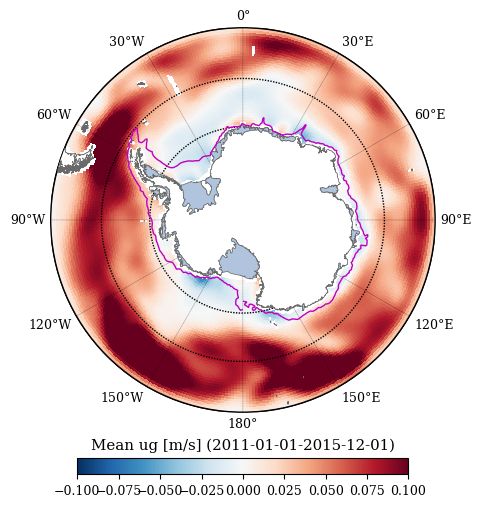

In [19]:
cbar_range = [-0.1, 0.1]
cmap = matplotlib.colormaps.get_cmap('RdBu_r')
cbar_units = ('Mean ug [m/s] (%s-%s)' % (date_start, date_end))

fig, ax, m = st.spstere_plot(eglon, eglat,
                             ug_mean,
                             cbar_range, cmap,
                             cbar_units, 'm')
plt.show()

### remove linear trend - altimetry

In [24]:
cbar_range = [-10, 10]
cmap = matplotlib.colormaps.get_cmap('RdBu_r')
#cmap = cm.get_cmap('RdBu_r', 31)

cbar_units = ('Linear trend (mm/yr) (%s-%s)' % (date_start, date_end))

In [138]:
dot_det, dot_slope, dot_pval = fc.detrend3d(alt_anom.dot)

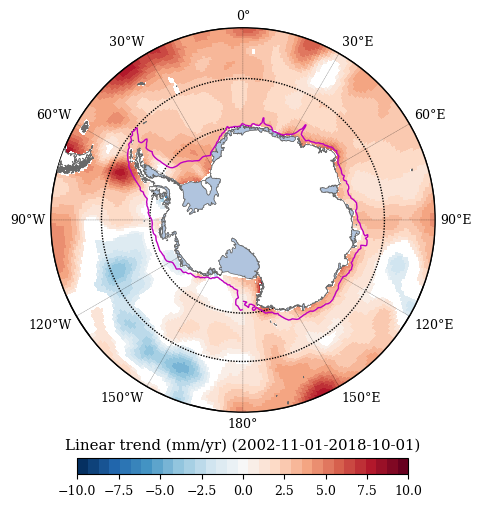

In [15]:
# trend in mm/yr with the GMSLR 
dot_slope_mm_yr = dot_slope * 1e3 * 365.25

# apply a mask to plot only trend values where p_val < 0.1
dot_slope_mm_yr[dot_pval>0.1] = np.nan

fig, ax, m = st.spstere_plot(eglon, eglat,
                             dot_slope_mm_yr,
                             cbar_range, cmap,
                             cbar_units, 'm')
plt.show()

In [139]:
# - - - - - - - - - - - - - - - - - 
# variables for EOF part 
# - - - - - - - - - - - - - - - - - 
alt_var = dot_det

alt_var_time = alt_var.time.dt.strftime('%m.%Y').values
alt_var_period = alt_var_time[0] + '-' + alt_var_time[-1]

# - - - - - - - - - - - - - - - - -
# apply weighting to account for meridians converging at high lat
coslat = np.cos(np.deg2rad(alt_var.latitude.values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(alt_var.T, weights=wgts)

neofs = 20
#eof = solver.eofsAsCorrelation(neofs=15)
eof = solver.eofsAsCovariance(neofs=neofs)
pc = solver.pcs(npcs=neofs, pcscaling=1)
variance_frac = solver.varianceFraction()

cumulative variance explained by first 3 modes:  45.37369541941677
cumulative variance explained by first 4 modes:  52.1294238023187
cumulative variance explained by first 5 modes:  57.20770265603928
cumulative variance explained by first 6 modes:  61.52729792574186
cumulative variance explained by first 7 modes:  65.52122922009411


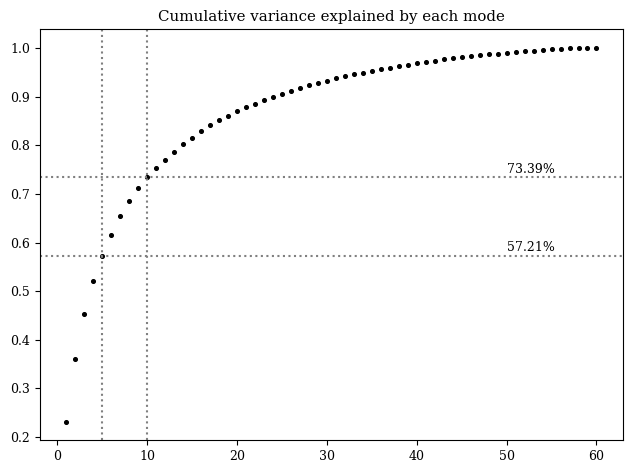

In [140]:
# - - - - - - - - - - - - - - - - -
# plot of cumulative variance for every mode 
# - - - - - - - - - - - - - - - - -
a = np.cumsum(variance_frac.values)
plt.ion()
fig, ax = plt.subplots()
ax.scatter(variance_frac.mode.values+1, a, s=7, c='k')
ax.axhline(a[9], ls=':', c='grey')
ax.axvline(10, ls=':', c='grey')
ax.annotate('{}{}'.format(str((a[9]*100).round(2)), '%'), 
  xy=(50, a[9]+0.01), xycoords='data')

ax.axhline(a[4], ls=':', c='grey')
ax.axvline(5, ls=':', c='grey')
ax.annotate('{}{}'.format(str((a[4]*100).round(2)), '%'), 
  xy=(50, a[4]+0.01), xycoords='data')
ax.set_title("Cumulative variance explained by each mode")
plt.tight_layout()

print("cumulative variance explained by first 3 modes: ", a[2]*1e2)
print("cumulative variance explained by first 4 modes: ", a[3]*1e2)
print("cumulative variance explained by first 5 modes: ", a[4]*1e2)
print("cumulative variance explained by first 6 modes: ", a[5]*1e2)
print("cumulative variance explained by first 7 modes: ", a[6]*1e2)

### North's rule
 difference between neighbouring eigenvalues (lambda) must be greater than their associated error; when that is nto the case, the eigenvalue is mixed (degenerate)

In [141]:
eigenvals = solver.eigenvalues(neigs=neofs)
errors = solver.northTest(neigs=neofs)

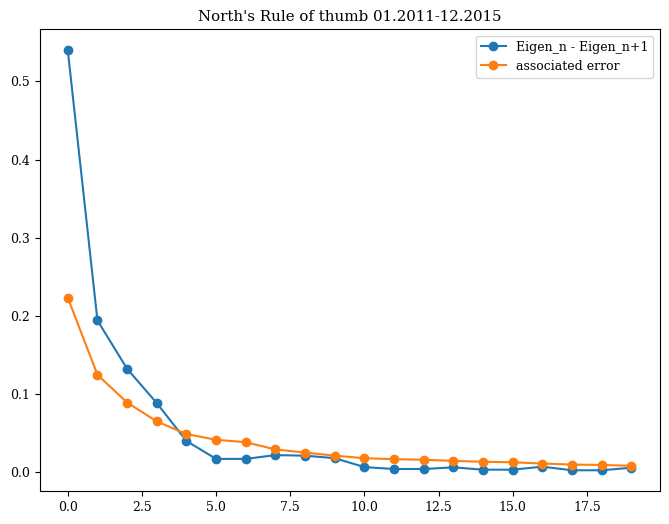

In [142]:
eg = eigenvals.data

diff1, diff2 = [0*np.ones(eg.shape) for _ in range(2)]
diff1[:-1] = abs(eg[:-1] - eg[1:])
diff2[1:] = abs(eg[1:] - eg[:-1])
diff2[0] = diff1[0]
diff1[-1] = diff2[-1]
diff_eg = np.minimum(diff1, diff2)

# associated error of neighbouring eigenvalues
err = errors.data
comb_error = np.sqrt(err[:-1]**2 + err[1:]**2)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(neofs), diff_eg, marker='o', label='Eigen_n - Eigen_n+1')
ax.plot(np.arange(neofs), err, marker='o', label='associated error')
ax.legend()
ax.set_title("North's Rule of thumb " + alt_var_period)
plt.show()
#fig.savefig(figdir + 'north_rule_all.png')

Getting coastlines north of 60 S ... 

Importing Antarctic Digital Database shapefile. 



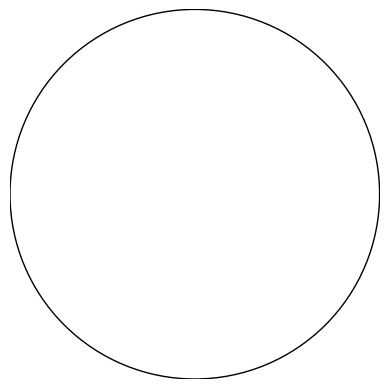

In [99]:
m = Basemap(projection='spstere',
            boundinglat=-50,
            lon_0=180,
            resolution='i',
            round=True)

# extract segments north of 60 S
print("Getting coastlines north of 60 S ... \n")
coast = m.drawcoastlines(linewidth=0)
segments = coast.get_segments()
lat_seg, lon_seg = [], []

for j in range(len(segments)):
    xy = np.vstack(segments[j]) 
    lons_b, lats_b = m(xy[:, 0], xy[:, 1], inverse=True)
    lats_bm = ma.masked_outside(lats_b, -60, -50.)
    lons_bm = ma.masked_array(lons_b, lats_bm.mask)
    if lats_bm.count() > 0:
        lat_seg.append(lats_bm)
        lon_seg.append(lons_bm)

# -----------------------
# coastlines south of 60S
print("Importing Antarctic Digital Database shapefile. \n")
# add path to coastline files
sys.path.append(coastdir)
from coastline_Antarctica import coastline

# extract coastline points from files (Tiago/Paul Holland)
## it returns a list of lists
[ilon_land, ilat_land, ilon_ice, ilat_ice] = coastline()

In [100]:
def spstere_plot(ax, varlon, varlat, var, vlims, cmap):
    #plt.ion()
    m = Basemap(projection='spstere',
            boundinglat=-50,
            lon_0=180,
            resolution='i',
            round=True, ax=ax)
    cs = m.pcolormesh(varlon, varlat, var,
                      vmin=vlims[0], vmax=vlims[1],
                      cmap=cmap,
                      latlon=True, 
                      rasterized=True,
                      shading='auto')
    m.drawcoastlines(linewidth=0.25)
    m.fillcontinents(color='w')
    
    for k in range(len(ilon_land)):
        xf, yf = m(ilon_land[k], ilat_land[k])
        xyf = np.c_[xf, yf]
        poly = polyg(xyf, facecolor='w', 
                    zorder=1, edgecolor='dimgrey',
                    linewidth=0.5, transform=ax.transData)
        ax.add_patch(poly)

    for k in range(len(ilon_ice)):
        xf, yf = m(ilon_ice[k], ilat_ice[k])
        xyf = np.c_[xf, yf]
        poly = polyg(xyf, facecolor='lightgrey',
                    zorder=2, edgecolor='dimgrey',
                    linewidth=0.5, transform=ax.transData)
        ax.add_patch(poly)

    for k in range(len(lat_seg)):
        m.plot(lon_seg[k], lat_seg[k], 
               lw=0.5, latlon=True, 
               zorder=2, c='dimgrey')
    
    # don't clip the map boundary circle
    circle = m.drawmapboundary(linewidth=.5, color='k')
    circle.set_clip_on(False)

    ax.set_rasterization_zorder(0)

    return ax, m, cs

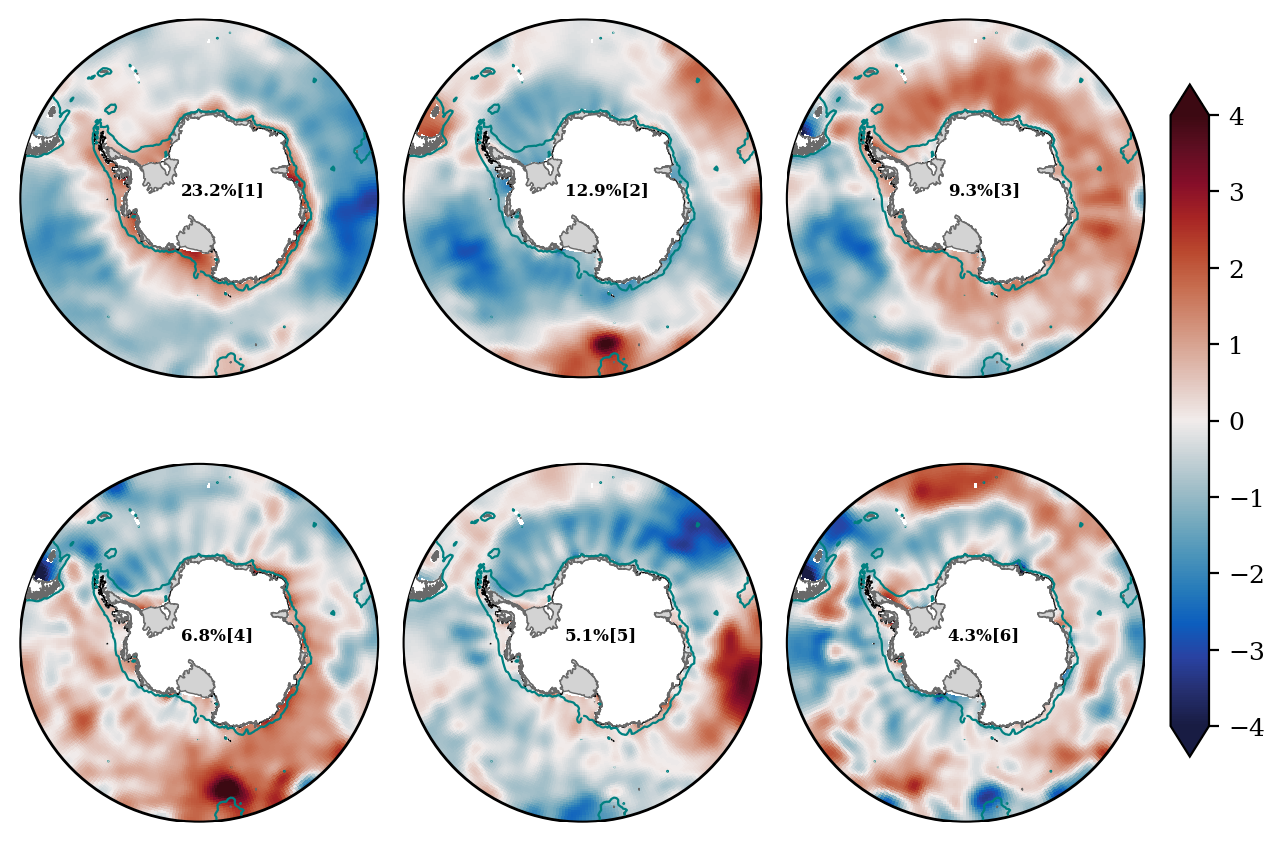

In [143]:
# - - - - - - - - - - - - - - - - - 
# >> circumpolar plots of EOFs
# - - - - - - - - - - - - - - - - -

cbar_range = [-4, 4]
cmap = Balance_19.mpl_colormap

fig, ax = plt.subplots(2, 3, dpi=200)
axs = ax.flatten()

for k in range(6):
    cbar_units = "(m/std)"
    std_k = eof[k].std(ddof=1)
    eof_stand = eof[k].values.T/std_k.values

    ax_k, m_k, cs_k = spstere_plot(axs[k], eglon, eglat, eof_stand,
                             cbar_range, cmap)

    lp = m_k.contour(tglon, tglat, topo.elevation,
          levels=[-1000],
          colors=['teal'], linewidths=.8, linestyles='-',
          latlon=True, zorder=2)

    ax_k.annotate("{:.1%}[{}]".format(variance_frac[k].values, str(k+1)),
              xy=(.45, 0.5),
              xycoords='axes fraction',
              ha='left', va='bottom',
              weight='bold', fontsize=6)
plt.tight_layout()
#cb = fig.colorbar(cs_k, ax=ax_k, 
#                  orientation='vertical',
#                  shrink=.7, pad=.07,
#                  extend='both')
#cb.ax.set_title(cbar_units)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(cs_k, cax=cbar_ax, extend='both')

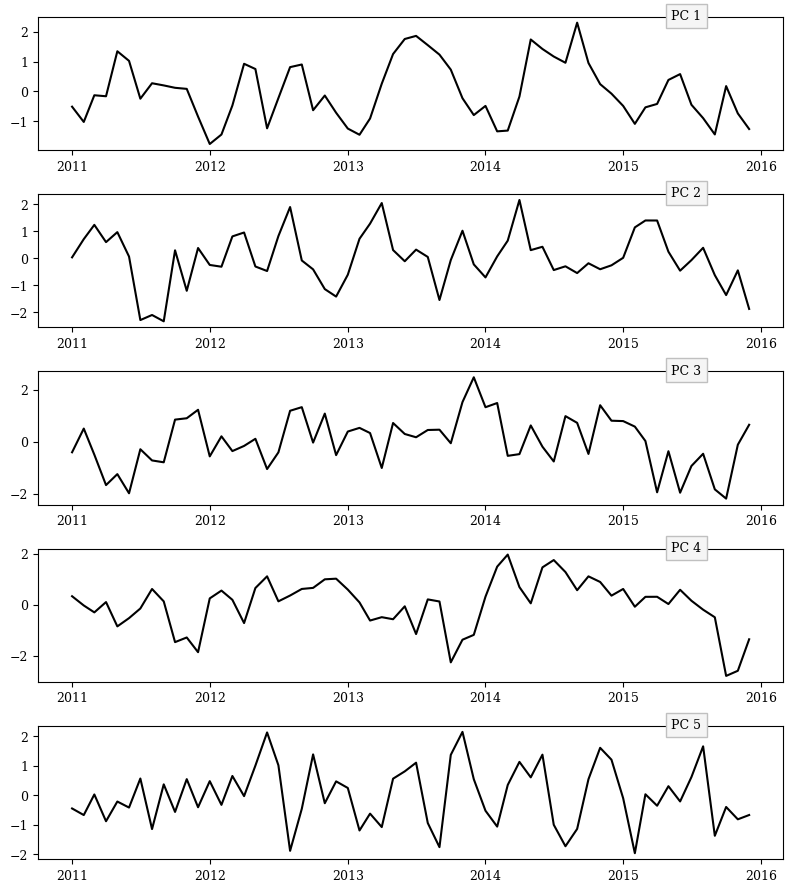

In [144]:
# - - - - - - - - - - - - - - - - - 
# time series of PC
# - - - - - - - - - - - - - - - - - 

k = 0
fig, axs = plt.subplots(nrows=5, figsize=(8,9))
[axs[i].plot(pc.time.values, pc[:, k+i], c='k', label='PC%s'%str(i+k+1)) for i in range(5)]
[axs[i].annotate('PC %s' % str(i+1),
                 xycoords='axes fraction', xy=(.85, .98), 
                 bbox=dict(alpha=1, fc='whitesmoke', ec='silver')) for i in range(5)]
plt.tight_layout() 

In [154]:
# - - - - - - - - - - - - - - - - - 
# reconstruct DOT
# - - - - - - - - - - - - - - - - - 
nm = 7 # number of modes to use
rec_dot = solver.reconstructedField(nm)

In [155]:
# - - - - - - - - - - - - - - - - - 
print("Computing gvel from rec DOT  ")
# - - - - - - - - - - - - - - - - - 
ug_rec, vg_rec = altim.geos_vel(rec_dot.values.T,
                                rec_dot.latitude,
                                rec_dot.longitude)

Computing gvel from rec DOT  


In [156]:
rec = xr.Dataset({'sla' : (('longitude', 'latitude', 'time'), rec_dot.T.values),
                  'ug' : (('longitude', 'latitude', 'time'), ug_rec),
                  'vg' : (('longitude', 'latitude', 'time'), vg_rec),
                 'percentage_explained' : (a[nm-1]*1e2)},
                  coords={'longitude' : rec_dot.longitude.values,
                          'latitude' : rec_dot.latitude.values,
                          'time' : rec_dot.time.values})


# prepare file to be saved
rec.coords["elon"] = alt.edge_lon.values
rec.coords["elat"] = alt.edge_lat.values

rec.sla.attrs['long_name'] = 'SLA_reconstructed_from_EOFs'
rec.attrs["description"] = "SLA reconstructed from first %s EOF modes." % str(nm)
rec.attrs['creation_time'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

In [157]:
# Convert to datetime objects
start_time_dt = pd.Timestamp(rec.time.min().values)
end_time_dt = pd.Timestamp(rec.time.max().values)

# Format as "MonthYear"
start_month_year = start_time_dt.strftime("%b%Y")
end_month_year = end_time_dt.strftime("%b%Y")

# Create the final string
time_range = f"{start_month_year}_{end_month_year}_"

new_filename = 'sla_' + str(nm) + "eof_" + time_range + geoidtype + ".nc"

In [158]:
rec.to_netcdf(griddir + new_filename)
print("File %s saved in %s" % (new_filename, griddir))

File sla_7eof_Jan2011_Dec2015_goco05c.nc saved in /Volumes/SamT5/PhD/PhD_data/altimetry_cpom/3_grid_dot/
